<a href="https://colab.research.google.com/github/xvdp/siren/blob/x_dev/siren_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siren Video stress test
Notes on tests for video

**Loss** is $ (x - y)^2 $ Decreases in few iterations very quickly; most of the computation for a video is required to smooth the high frequency details and sharp boundaries.

**Sampling** strategy differs from sampling of a single image. In the first case the image is loaded as a single instance. The current loaders load the video in RAM but cannot load entire data to GPU, choosing a single uniform random sample of size *batch_size*- which may be repeated - per epoch. (pass stragegy=-1)

Ensuring complete non repeating sampling per epoch (strategy=1) results in worse performance, as does passing complete contiguous blocks of data. Possibly the repetition of some samples regularizes the loss preventing overfitting.

**Batch size** will depend on GPU availability.
Supplementary Info pg. 16
"*The Adam optimizer with a learning rate of1×10−4was used for all experi-ments. We set the batch size to fill the memory of the GPUs (roughly 160,000)"
"We train the videos for 100,000 iterations, requiring approximately 15 hours."*

 Batch or sample size on this colab ~ 320000 - each iteration is taking 2s, making training of a small video, ~ 57 hours, a bit much. On a local machine with TitanGTX 24G - computation took 23 hours.





In [1]:
!pip install git+https://github.com/xvdp/vidi.git
!rm -rf siren/
!git clone -b x_dev https://github.com/xvdp/siren.git

  Cloning https://github.com/xvdp/vidi.git to /tmp/pip-req-build-l5r_2ah3
  Running command git clone -q https://github.com/xvdp/vidi.git /tmp/pip-req-build-l5r_2ah3
  Created wheel for vidi: filename=vidi-0.1-cp37-none-any.whl size=25732 sha256=f38c84b923a070a9fecf9d309a7b29c0e304fc69d245275f7ff0d6148264875e
  Stored in directory: /tmp/pip-ephem-wheel-cache-jymcdi54/wheels/eb/af/bf/d3d553233ac4ba8401e2c03425734897d87fcb779db2b27f14
Successfully built vidi
Cloning into 'siren'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 299 (delta 61), reused 65 (delta 29), pack-reused 193
Receiving objects: 100% (299/299), 10.61 MiB | 20.23 MiB/s, done.
Resolving deltas: 100% (128/128), done.


In [2]:
import os
import os.path as osp
import yaml
import torch
os.chdir("siren")
import x_utils
import x_dataio
import x_modules
from x_training import train, _continue, load_last_checkpoint, _prevent_overwrite

## check available GPU and CPU

In [3]:
x_utils.GPUse(), x_utils.CPUse()

(GPU: ({'total': 15109, 'used': 0, 'available': 15109, 'percent': 0.0, 'units': 'MB'}),
 CPU: ({'total': 12993, 'used': 610, 'available': 12110, 'percent': 6.8, 'units': 'MB'}))

## download cat video
from https://drive.google.com/drive/u/0/folders/1_iq__37-hw7FJOEUK1tX7mdp8SKB368K

In [4]:
#https://drive.google.com/file/d/1ZCr6HTrNu8f6T-nyIbToYXHMOKU88f7P/view?usp=sharing
!gdown --id 1ZCr6HTrNu8f6T-nyIbToYXHMOKU88f7P 

Downloading...
From: https://drive.google.com/uc?id=1ZCr6HTrNu8f6T-nyIbToYXHMOKU88f7P
To: /content/siren/cat_video.mp4
4.49MB [00:00, 39.7MB/s]


In [5]:
os.rename("cat_video.mp4", "data/cat_video.mp4")

convert video for display

In [17]:
!ffmpeg -i data/cat_video.mp4 -vcodec libx264 -pix_fmt yuv420p -profile:v baseline -level 3 data/cat_video_web.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [18]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open("data/cat_video_web.mp4","rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=512 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## connect gdrive to colab and redirect logging root

In [6]:
from google.colab import drive
drive_dir = '/content/gdrive'
drive.mount(drive_dir)

Mounted at /content/gdrive


In [7]:
logging_root = "/content/gdrive/MyDrive/siren"
os.makedirs(logging_root, exist_ok=True)
osp.isdir(logging_root)

True

In [8]:
# Easy_Dict is a dictionary accessible as object ( not pypi EasyDict )
config_file = "x_periment_scripts/cat_s-1_100k.yml"
with open(config_file, "r") as _fi:
    opt = x_utils.EasyDict(yaml.load(_fi,)) # Loader=yaml.FullLoader 

In [9]:
opt.logging_root = logging_root
config_file = "_colab".join(osp.splitext(config_file))
opt.to_yaml(config_file)
print(opt.logging_root, config_file, osp.isfile(config_file))

/content/gdrive/MyDrive/siren x_periment_scripts/cat_s-1_100k_colab.yml True


### training options differ from main branch: containing:
* model definition
* strategy  [-1] original, fully random single sample per epoch
 [1] complete set of non repeating samples per epoch [2] grided sampling, dense and sparse : original strategy works best
* sample_frac: None, is estimated from GPU available
* sample_size: estimated below


In [10]:
gpus = x_utils.GPUse()
# sample size is multiplied * 2 over the estimate, probably gradient operations over latents are optimized
# ergo single operations (sin, +, *) do not save full new latent gradient 
opt.sample_size = x_utils.estimate_samples(gpus.available, **opt["siren"])*2 
opt.epochs_til_checkpoint = 5000 # lower epochs till checkpoint, just in case, colab may boot us out

In [11]:
opt

{'batch_size': 1,
 'checkpoint_path': None,
 'data_path': './data/cat_video.mp4',
 'epochs_til_checkpoint': 5000,
 'experiment_name': 'cat_s-1_100k',
 'frame_range': None,
 'logging_root': '/content/gdrive/MyDrive/siren',
 'lr': 0.0001,
 'model_type': 'sine',
 'num_epochs': 100000,
 'num_steps': 100000,
 'sample_frac': None,
 'sample_size': 321482,
 'shuffle': 1,
 'siren': {'first_omega_0': 30,
  'hidden_features': 1024,
  'hidden_layers': 3,
  'hidden_omega_0': 30.0,
  'in_features': 3,
  'out_features': 3,
  'outermost_linear': True},
 'steps_til_summary': 1,
 'strategy': -1,
 'train_type': 'video',
 'verbose': 1}

## in this instance, sample_size is estimated at 321,480 float32
~2x the spec on the paper (160,000) 

**Does this mean that instead of 100k iterations similar loss will be reaches in 50k operations?**

Running the same experiments with the other strategies demonstrates that the a uniform random sampling (i.e. original strategy, -1), has  nearly monotonic convergence whereas running randomly repeating grids (strategy 2) or, non repeating complete random samples over the data ( strategy 1), overfits some data. 

These experimients will not be run here but to test wsuffices to set opt.strategy = 1 or 2



# VideoDataset is modificiation over main branch.
* Does not create m_grid then referenceit but finds grid pos from random index
* different strategies. see x_dataio.VideoDataset

In [12]:
dset = x_dataio.VideoDataset(opt.data_path, sample_size=opt.sample_size, frame_range=opt.frame_range, strategy=opt.strategy)

Siren: VideoDataset - INFO - Loaded data, sidelen: [300, 512, 512], channels 3
Siren: VideoDataset - INFO -          => reshaped to: (78643200, 3)
Siren: VideoDataset - INFO -  max sample_size, 321482, fraction, 0.0041
Siren: VideoDataset - INFO -  strategy: -1, single sample per epoch


In [13]:
dataloader = torch.utils.data.DataLoader(dset, shuffle=opt.shuffle, batch_size=1, pin_memory=True, num_workers=0)

## store training options to yaml

In [14]:
opt.sidelen = tuple(dset.data.shape[:-1])
opt.chanels = dset.data.shape[-1]
opt.sample_size = dset.sample_size
opt.dset_len = len(dset)
if "num_steps" not in opt:
    opt.num_steps = None
folder = osp.join(opt.logging_root, opt.experiment_name)
opt.to_yaml(osp.join(folder, "training_options.yml"))

## create model and run
Siren used in this instance is simplified - meta nodes disabled

In [15]:
model = x_modules.Siren(**opt["siren"])
model.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=1024, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (4): Linear(in_features=1024, out_features=3, bias=True)
  )
)

# Process suspendend, at 2.09s/iteration, 100k: ~57 hours

In [16]:
checkpoint = train(model, dataloader, opt.num_epochs, opt.lr, opt.epochs_til_checkpoint, folder, dataset=dset,
                   num_steps=opt.num_steps, steps_til_summary=100, terminator={"end":"\n"})

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


Epoch	Iter	IterAll	tGPU	GPU	CPU	Loss	Time	Total_Time
999	0	999	13878	14962	4047	0.0176	2.09	2086
1999	0	1999	13878	14962	4059	0.0149	2.09	4183
2999	0	2999	13878	14962	4061	0.0142	2.09	6278
3999	0	3999	13878	14962	4062	0.0139	2.09	8375
4999	0	4999	13878	14962	4063	0.0134	2.09	10470

Finished at epoch 5236, checkpoint/content/gdrive/MyDrive/siren/cat_s-1_100k/model_final.pth


## Render partial result
* delete training, render from checkpoint 
could render from model. 



In [31]:
sidelen = dset.sidelen.tolist()
del model
del dset
del dataloader

In [36]:
sidelen

[300, 512, 512]

In [34]:
checkpoint = "/content/gdrive/MyDrive/siren/cat_s-1_100k/model_final.pth"
osp.isfile(checkpoint), osp.isdir(logging_root)

(True, True)

In [58]:
import x_infer
from x_infer import SirenRender, render_video

In [37]:
with torch.no_grad():
    # model.eval()
    chunksize = int(x_utils.estimate_frames(sidelen[-2:], grad=0)//0.5)
    render = x_utils.EasyDict(model=checkpoint, sidelen=sidelen, chunksize=chunksize)
    render.name = osp.join(folder, "cat_recon_{:04}.mp4".format(5000))
    render.fps = 25
    S = SirenRender(**render)



Siren: Render - INFO - loading model from checkpoint: /content/gdrive/MyDrive/siren/cat_s-1_100k/model_final.pth


In [38]:
S.render_video()

Siren: Render - INFO - Rendering /content/gdrive/MyDrive/siren/cat_s-1_100k/cat_recon_5000.mp4: 300,(512, 512),3, chunks: 3
Siren: Render - INFO - 
 Finished render /content/gdrive/MyDrive/siren/cat_s-1_100k/cat_recon_5000.mp4, to play result call: >>> self.play()


In [42]:
render = "/content/gdrive/MyDrive/siren/cat_s-1_100k/cat_recon_5000.mp4"
cat = "data/cat_video.mp4"
comp = "/content/gdrive/MyDrive/siren/cat_s-1_100k/composite.mp4"
osp.isfile(render), osp.isfile(cat)

(True, True)

# Looks like an error in channels,
TODO: debug. indexing

In [52]:
output_size = [chunksize, *sidelen[1:], 3]
output_size

[2, 512, 512, 3]

In [44]:
# something not right with the composite
# !ffmpeg -i $render -i $cat -filter_complex "[0:v][1:v]hstack,format=yuv420p[v];[0:a][1:a]amerge[a]" -map "[v]" -map "[a]" -c:v libx264 -crf 18 -ac 2 $comp


In [45]:
mp4 = open(render,"rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=512 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [48]:
chunksize, sidelen

(2, [300, 512, 512])

In [55]:
render2 = "/content/gdrive/MyDrive/siren/cat_s-1_100k/cat_recon2.mp4"

#render_video(checkpoint, render2, sidelen=sidelen, chunksize=1, loop=1 )

In [59]:
model, channels = x_infer.model_from_checkpoint(checkpoint)

In [69]:
import numpy as np
import matplotlib.pyplot as plt

In [84]:
coords = x_dataio.get_mgrid([2,4,5], [[1,2]], indices=True)
coords

tensor([[1, 0, 0],
        [1, 0, 1],
        [1, 0, 2],
        [1, 0, 3],
        [1, 0, 4],
        [1, 1, 0],
        [1, 1, 1],
        [1, 1, 2],
        [1, 1, 3],
        [1, 1, 4],
        [1, 2, 0],
        [1, 2, 1],
        [1, 2, 2],
        [1, 2, 3],
        [1, 2, 4],
        [1, 3, 0],
        [1, 3, 1],
        [1, 3, 2],
        [1, 3, 3],
        [1, 3, 4]])

In [101]:
x_dataio.get_mgrid([2,4,5], [[0,1]])

tensor([[-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.5000],
        [-1.0000, -1.0000,  0.0000],
        [-1.0000, -1.0000,  0.5000],
        [-1.0000, -1.0000,  1.0000],
        [-1.0000, -0.3333, -1.0000],
        [-1.0000, -0.3333, -0.5000],
        [-1.0000, -0.3333,  0.0000],
        [-1.0000, -0.3333,  0.5000],
        [-1.0000, -0.3333,  1.0000],
        [-1.0000,  0.3333, -1.0000],
        [-1.0000,  0.3333, -0.5000],
        [-1.0000,  0.3333,  0.0000],
        [-1.0000,  0.3333,  0.5000],
        [-1.0000,  0.3333,  1.0000],
        [-1.0000,  1.0000, -1.0000],
        [-1.0000,  1.0000, -0.5000],
        [-1.0000,  1.0000,  0.0000],
        [-1.0000,  1.0000,  0.5000],
        [-1.0000,  1.0000,  1.0000]])

In [89]:
data = torch.stack([torch.ones([4,5,3]), torch.zeros([4,5,3])])
print(data.shape)
data = data.view(-1, data.shape[-1])
print(data.shape)

torch.Size([2, 4, 5, 3])
torch.Size([40, 3])


In [99]:
cords = torch.arange(3,8)
coords = 2*x_dataio.expand_igrid(cords, torch.tensor([2,4,5]))/(torch.tensor([2,4,5])-1) -1
#coords = 2*expand_igrid(coords, sidelen)/(self.sidelen-1) - 1

In [100]:
coords

tensor([[-1.0000, -1.0000,  0.5000],
        [-1.0000, -1.0000,  1.0000],
        [-1.0000, -0.3333, -1.0000],
        [-1.0000, -0.3333, -0.5000],
        [-1.0000, -0.3333,  0.0000]])

In [ ]:
coords = torch.randint(0, self.data.shape[0], (self.sample_size,))
c2 = 2*x_dataio.expand_igrid(coords, self.sidelen)/(self.sidelen-1) - 1

In [66]:

#render single frame
with torch.no_grad():
    model.to(device="cuda").eval()
    coords = x_dataio.get_mgrid(sidelen, [[0,1]]).cuda()
    out = model(coords)
    out = np.clip((out.cpu().detach().numpy() * 0.5 + 0.5), 0, 1.0)

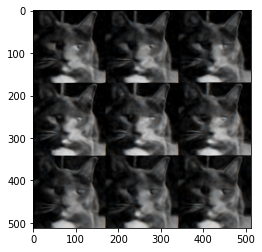

In [70]:
plt.imshow(out.reshape(512,512,3))

In [54]:
mp4 = open(render2,"rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=512 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)